In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import editdistance

# --- CONFIGURATION ---
BATCH_SIZE = 32
LR = 0.0003
EPOCHS = 50
IMG_W = 160
IMG_H = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your character set (Must include all possible chars in your captchas)
CHARSET = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
NUM_CHARS = len(CHARSET)
CHAR_TO_IDX = {char: i + 1 for i, char in enumerate(CHARSET)} # 0 is reserved for CTC blank
IDX_TO_CHAR = {i: char for char, i in CHAR_TO_IDX.items()}



In [ ]:
# --- DATASET ---
class CaptchaSequenceDataset(Dataset):
    def __init__(self, root_dir, subset, transform=None):
        self.root_dir = os.path.join(root_dir, subset)
        self.img_dir = os.path.join(self.root_dir, "images")
        with open(os.path.join(self.root_dir, "labels.json"), "r") as f:
            self.labels_dict = json.load(f)
        self.filenames = list(self.labels_dict.keys())
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        text = self.labels_dict[fname]['captcha']
        target = [CHAR_TO_IDX[c] for c in text]
        target_len = len(target)
        
        return image, torch.LongTensor(target), torch.LongTensor([target_len])

def collate_fn(batch):
    images, targets, target_lens = zip(*batch)
    images = torch.stack(images)
    # Pack targets into a single flat vector for CTCLoss
    flat_targets = torch.cat(targets)
    target_lens = torch.cat(target_lens)
    return images, flat_targets, target_lens

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_chars, hidden_size=256):
        super(CRNN, self).__init__()
        
        # CNN to extract features and reduce Height to 1
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),      # 64x32x80
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),     # 128x16x40
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 2)), # 256x8x20
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 2)), # 512x4x10
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU(),                      # 512x3x9 (Approx)
            nn.AdaptiveAvgPool2d((1, None))                                # 512x1xWidth
        )
        
        # input_size = 512 because height is now 1
        self.rnn = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_chars + 1)

    def forward(self, x):
        x = self.cnn(x)              # [B, 512, 1, W_feat]
        x = x.squeeze(2)             # [B, 512, W_feat]
        x = x.permute(0, 2, 1)       # [B, W_feat, 512]
        x, _ = self.rnn(x)           # [B, W_feat, 2*hidden]
        x = self.fc(x)               # [B, W_feat, num_chars+1]
        return x.permute(1, 0, 2).log_softmax(2) # [W_feat, B, num_chars+1] for CTC

# --- DECODING & TRAINING ---
def decode_prediction(output):
    arg_maxes = torch.argmax(output, dim=2).permute(1, 0)
    decoded_texts = []
    for i in range(arg_maxes.size(0)):
        res = []
        prev = 0
        for char_idx in arg_maxes[i]:
            if char_idx != 0 and char_idx != prev:
                res.append(IDX_TO_CHAR[char_idx.item()])
            prev = char_idx
        decoded_texts.append("".join(res))
    return decoded_texts

In [ ]:
predict_transform = transforms.Compose([
    transforms.Resize((IMG_H, IMG_W)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_trained_model(weights_path):
    model = CRNN(NUM_CHARS) 
    state_dict = torch.load(weights_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    model.eval()
    return model

def predict_captcha(model, image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = predict_transform(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits = model(image_tensor)
        # Decode the CTC output
        prediction = decode_prediction(logits)[0]
    return prediction


def visualize_test_results(model, dataset, transform, device, num_samples=10):
    """
    Picks random images from the dataset and plots them with predicted vs actual text.
    Colors the title GREEN if correct, RED if there is any mismatch.
    """
    model.eval()
    
    # Handle ConcatDataset vs standard Dataset
    if isinstance(dataset, torch.utils.data.Subset):
        # If it's a subset (from random_split), we need the underlying dataset
        base_ds = dataset.dataset
        indices = [dataset.indices[i] for i in np.random.choice(len(dataset), num_samples, replace=False)]
    else:
        base_ds = dataset
        indices = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(20, 10))
    cols = 5
    rows = (num_samples + cols - 1) // cols

    for i, idx in enumerate(indices):
        if hasattr(base_ds, 'datasets'):
            dataset_idx = 0
            while idx >= len(base_ds.datasets[dataset_idx]):
                idx -= len(base_ds.datasets[dataset_idx])
                dataset_idx += 1
            current_ds = base_ds.datasets[dataset_idx]
        else:
            current_ds = base_ds
            
        fname = current_ds.filenames[idx]
        img_path = os.path.join(current_ds.img_dir, fname)
        actual_text = current_ds.labels_dict[fname]['word']
        
        pred_text = predict_captcha(model, img_path)
        
        ax = plt.subplot(rows, cols, i + 1)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        
        color = 'green' if pred_text == actual_text else 'red'
        
        plt.title(f"Actual: {actual_text}\nPred: {pred_text}", 
                  color=color, fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def run_pipeline(model, model_path, EPOCHS=50):
    transform = transforms.Compose([
        transforms.Resize((IMG_H, IMG_W)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Dataset setup
    easy_set = CaptchaSequenceDataset("dataset_final", "easy", transform=transform)
    hard_set = CaptchaSequenceDataset("dataset_final", "hard", transform=transform)
    full_dataset = torch.utils.data.ConcatDataset([easy_set, hard_set])
    
    train_size = int(0.8 * len(full_dataset))
    train_db, test_db = torch.utils.data.random_split(full_dataset, [train_size, len(full_dataset)-train_size])
    
    train_loader = DataLoader(train_db, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_db, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # --- HISTORY TRACKING ---
    history = {
        'train_loss': [],
        'test_cer': []
    }
    best_cer = float('inf')

    for epoch in range(EPOCHS):
        # Training Phase
        model.train()
        epoch_loss = 0
        for imgs, targets, target_lens in train_loader:
            imgs = imgs.to(DEVICE)
            optimizer.zero_grad()
            logits = model(imgs)
            T, B, _ = logits.size()
            input_lens = torch.full(size=(B,), fill_value=T, dtype=torch.long)
            loss = criterion(logits, targets, input_lens, target_lens)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation/Test Phase (CER Evaluation)
        model.eval()
        char_errs, total_chars = 0, 0
        with torch.no_grad():
            for imgs, targets, target_lens in test_loader:
                imgs = imgs.to(DEVICE)
                logits = model(imgs)
                preds = decode_prediction(logits)
                offset = 0
                for i, length in enumerate(target_lens):
                    actual = "".join([IDX_TO_CHAR[x.item()] for x in targets[offset:offset+length]])
                    offset += length
                    char_errs += editdistance.eval(preds[i], actual)
                    total_chars += len(actual)

        avg_loss = epoch_loss / len(train_loader)
        cer = (char_errs / total_chars) * 100 if total_chars > 0 else 0
        
        history['train_loss'].append(avg_loss)
        history['test_cer'].append(cer)

        # --- SAVING LOGIC ---
        status_msg = ""
        if cer < best_cer:
            best_cer = cer
            torch.save(model.state_dict(), "best_rcnn_model.pth")
            status_msg = " [Best Model Saved!]"

        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | CER: {cer:.2f}%{status_msg}")

    # Save final weights
    torch.save(model.state_dict(), f"{model_path}.pth")

    # --- PLOTTING SECTION ---
    plt.figure(figsize=(12, 5))

    # Plot CTC Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training CTC Loss', color='blue')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Character Error Rate (CER)
    plt.subplot(1, 2, 2)
    plt.plot(history['test_cer'], label='Test CER (%)', color='red')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('Epochs')
    plt.ylabel('Error %')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Optional: Visualize some actual predictions after training
    visualize_test_results(model, test_db.dataset, transform, DEVICE)

    

Epoch 1/30 | Loss: 3.5173 | CER: 100.00% [Best Model Saved!]
Epoch 2/30 | Loss: 3.1627 | CER: 100.00%
Epoch 3/30 | Loss: 2.9851 | CER: 89.52% [Best Model Saved!]
Epoch 4/30 | Loss: 2.7548 | CER: 82.39% [Best Model Saved!]
Epoch 5/30 | Loss: 2.5481 | CER: 90.30%
Epoch 6/30 | Loss: 2.3352 | CER: 64.82% [Best Model Saved!]
Epoch 7/30 | Loss: 2.0629 | CER: 66.06%
Epoch 8/30 | Loss: 1.7791 | CER: 56.27% [Best Model Saved!]
Epoch 9/30 | Loss: 1.5188 | CER: 48.95% [Best Model Saved!]
Epoch 10/30 | Loss: 1.2281 | CER: 49.50%
Epoch 11/30 | Loss: 0.9779 | CER: 32.02% [Best Model Saved!]
Epoch 12/30 | Loss: 0.7442 | CER: 25.07% [Best Model Saved!]
Epoch 13/30 | Loss: 0.5408 | CER: 21.04% [Best Model Saved!]
Epoch 14/30 | Loss: 0.3980 | CER: 23.19%
Epoch 15/30 | Loss: 0.2752 | CER: 14.78% [Best Model Saved!]
Epoch 16/30 | Loss: 0.1814 | CER: 13.31% [Best Model Saved!]
Epoch 17/30 | Loss: 0.1228 | CER: 11.30% [Best Model Saved!]
Epoch 18/30 | Loss: 0.0861 | CER: 11.71%
Epoch 19/30 | Loss: 0.0587 | 

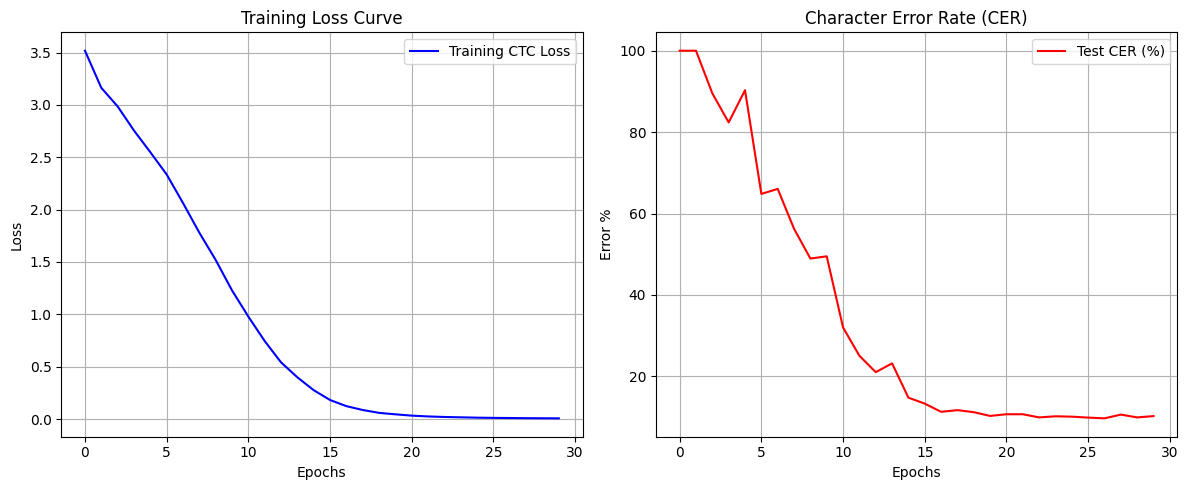

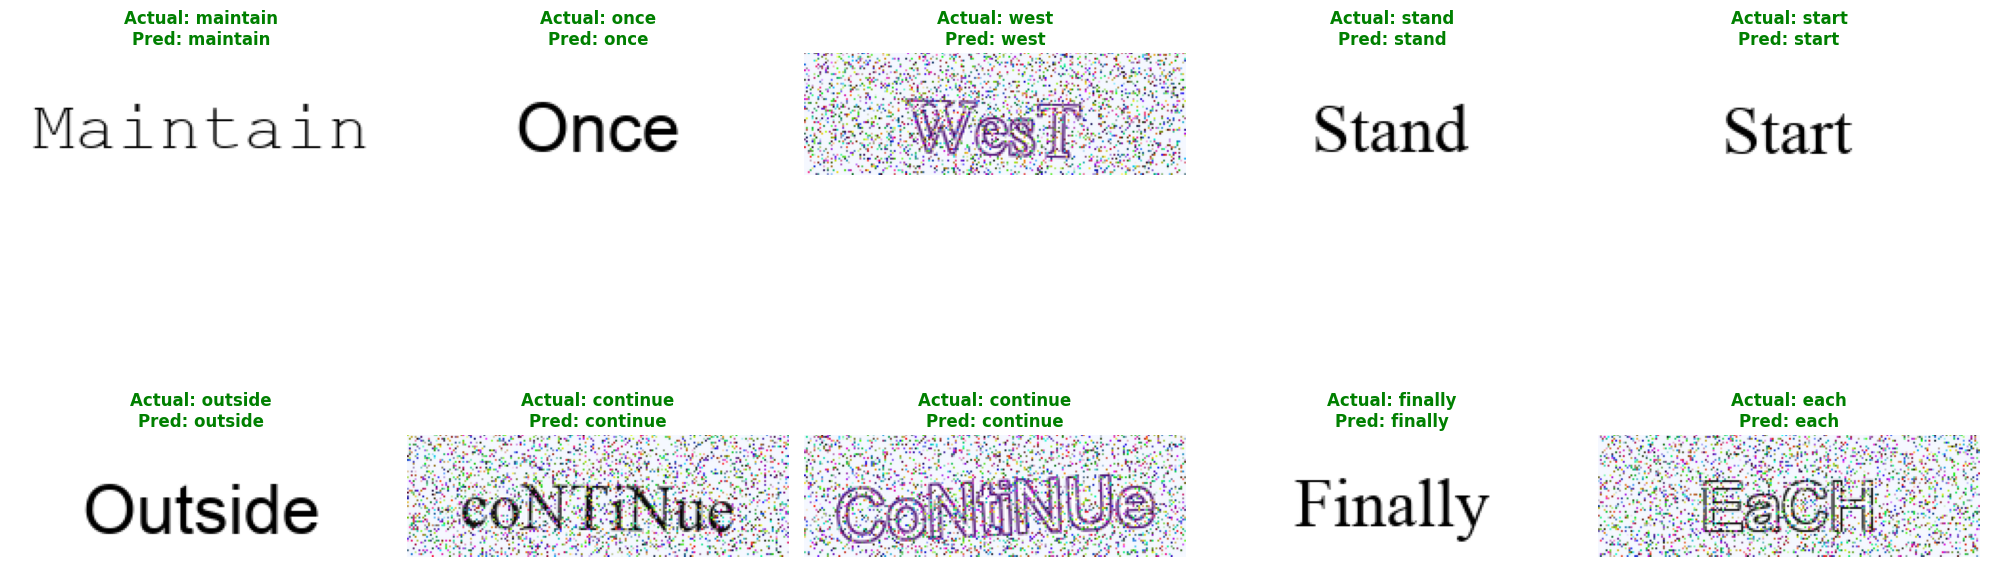

In [ ]:
model = CRNN(NUM_CHARS).to(DEVICE)
model_path = "best_rcnn_model"
run_pipeline(model, model_path, EPOCHS=30)

In [ ]:
model = load_trained_model("best_rcnn_model.pth")

print(predict_captcha(model, "/Users/coschool/Desktop/proj/precog/dataset_final/easy/images/able_v0.png"))
print(predict_captcha(model, "/Users/coschool/Desktop/proj/precog/dataset_final/easy/images/accept_v6.png"))
print(predict_captcha(model, "/Users/coschool/Desktop/proj/bonus/dataset_final/easy/images/accept_v5.png"))

'accept'

## Method 2 : Advanced CRNN

Epoch 1/5 | Loss: 1.7718 | CER: 76.98% [Best Model Saved!]
Epoch 2/5 | Loss: 1.2504 | CER: 70.31% [Best Model Saved!]
Epoch 3/5 | Loss: 0.7704 | CER: 55.46% [Best Model Saved!]
Epoch 4/5 | Loss: 0.3681 | CER: 49.67% [Best Model Saved!]
Epoch 5/5 | Loss: 0.1806 | CER: 44.77% [Best Model Saved!]


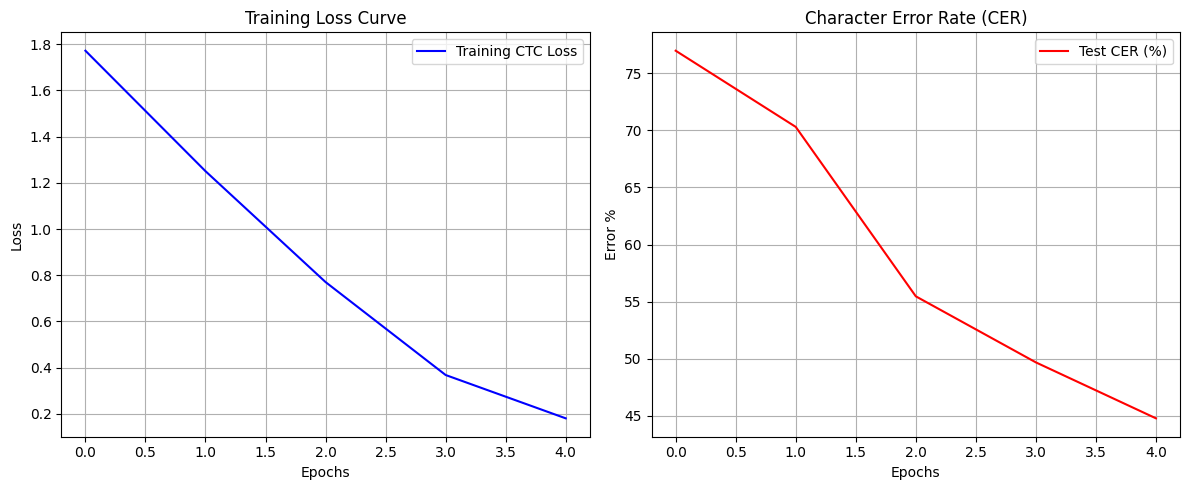

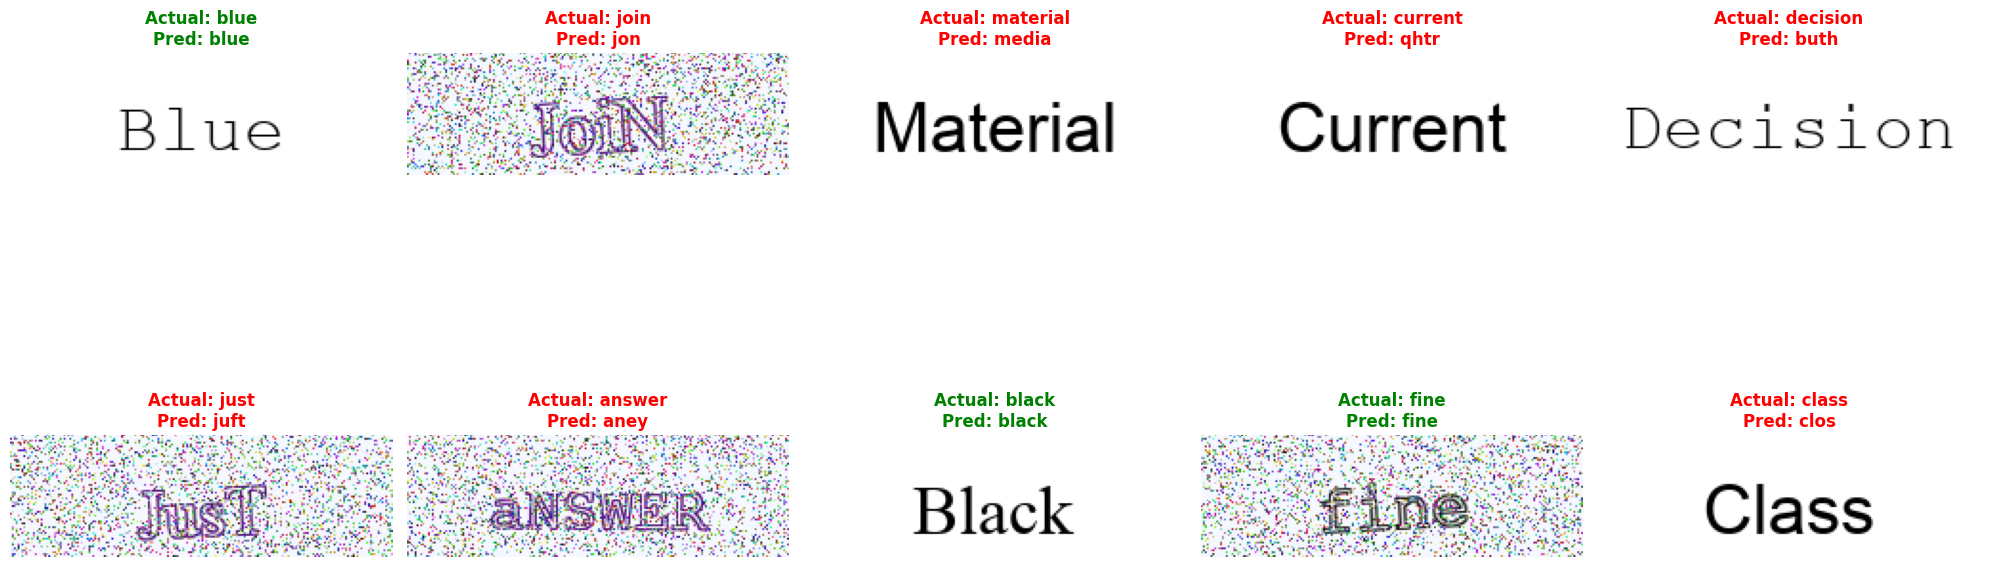

In [21]:
import torch.nn.functional as F
from torchvision import models

class AdvancedCRNN(nn.Module):
    def __init__(self, num_chars, hidden_size=256):
        super(AdvancedCRNN, self).__init__()
        try:
            resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        except:
            # Fallback for older torchvision versions
            resnet = models.resnet18(pretrained=True)
            
        # 2. Extract only the convolutional layers (exclude avgpool and fc)
        # ResNet18 downsamples the image by 32x. 
        # If input is 64x160, output will be 2x5 (too small!)
        # So we modify the first few layers to keep the resolution higher.
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        # 3. Fix the Height dimension ResNet18 output has 512 channels. We collapse height to 1.
        self.pool = nn.AdaptiveAvgPool2d((1, None)) 
        
        # 4. Sequence Modeling (Bi-LSTM) input_size is 512 (from ResNet channels)
        self.rnn = nn.LSTM(512, hidden_size, bidirectional=True, 
                           batch_first=True, num_layers=2, dropout=0.2)
        
        # 5. Output Layer
        self.fc = nn.Linear(hidden_size * 2, num_chars + 1)

    def forward(self, x):
        # CNN: [Batch, 3, 64, 160] -> [Batch, 512, 2, 5]
        x = self.backbone(x)         
        
        # Pool: [Batch, 512, 1, 5]
        x = self.pool(x)             
        
        # Prepare for RNN: [Batch, 5, 512]
        x = x.squeeze(2).permute(0, 2, 1) 
        
        # RNN: [Batch, 5, 512]
        x, _ = self.rnn(x)
        
        # FC: [Batch, 5, num_chars + 1]
        x = self.fc(x)
        
        # CTC Format: [Time, Batch, Classes]
        return x.permute(1, 0, 2).log_softmax(2)
    

model = AdvancedCRNN(NUM_CHARS).to(DEVICE)
model_path = "best_advanced_crnn_model"
run_pipeline(model, model_path, EPOCHS=5)

## TrOCR

### LSTMs in CRNNs often "forget" the beginning of a long captcha by the time they reach the end. Transformers have a constant "path length" between any two pixels.

Epoch 1/5 | Loss: 3.3582 | CER: 91.00% [Best Model Saved!]
Epoch 2/5 | Loss: 2.1387 | CER: 42.54% [Best Model Saved!]
Epoch 3/5 | Loss: 0.8995 | CER: 19.04% [Best Model Saved!]
Epoch 4/5 | Loss: 0.2951 | CER: 10.61% [Best Model Saved!]
Epoch 5/5 | Loss: 0.1180 | CER: 9.66% [Best Model Saved!]


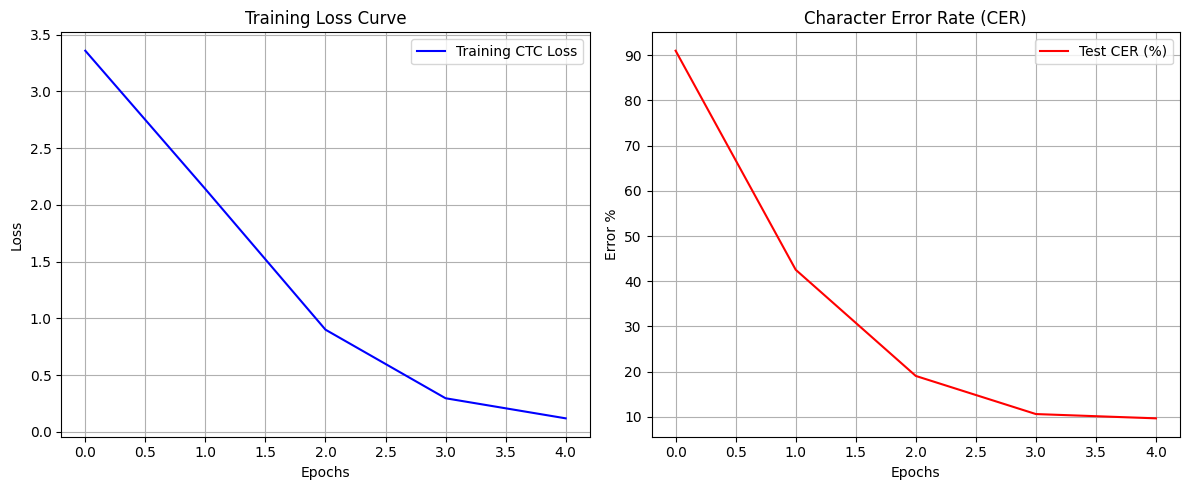

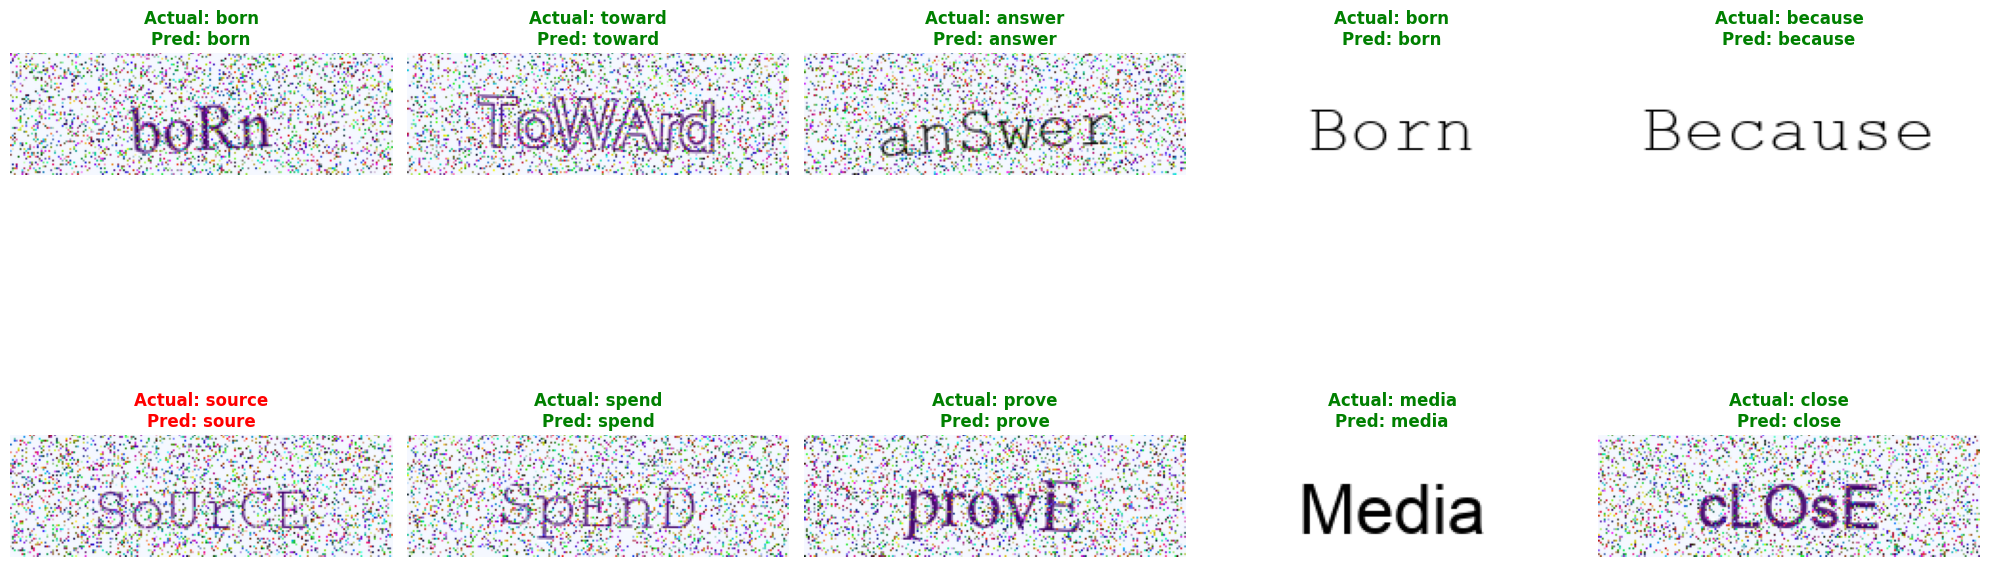

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [Batch, Seq_Len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerOCR(nn.Module):
    def __init__(self, num_chars, d_model=256, nhead=8, num_layers=4):
        super(TransformerOCR, self).__init__()
        
        # 1. CNN Feature Extractor (ResNet backbone)
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        # 2. Project CNN features to Transformer dimension
        self.conv_proj = nn.Conv2d(512, d_model, kernel_size=1)
        
        # 3. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 5. Output mapping to characters
        # Note: We still use CTC loss here for easier alignment
        self.fc = nn.Linear(d_model, num_chars + 1)

    def forward(self, x):
        # x: [Batch, 3, 64, 160]
        features = self.backbone(x)        # [B, 512, H_feat, W_feat]
        features = self.conv_proj(features) # [B, d_model, H_feat, W_feat]
        
        # Flatten H and W into a sequence of "visual tokens"
        b, c, h, w = features.size()
        features = features.flatten(2).permute(0, 2, 1) # [B, H*W, d_model]
        
        # Add spatial information
        features = self.pos_encoder(features)
        
        # Transformer processing
        out = self.transformer_encoder(features) # [B, Seq_Len, d_model]
        
        # Project to character classes
        logits = self.fc(out) # [B, Seq_Len, num_chars + 1]
        
        # CTC expects [Seq_Len, Batch, Classes]
        return logits.permute(1, 0, 2).log_softmax(2)
    
model = TransformerOCR(NUM_CHARS, d_model=256).to(DEVICE)
model_path = "best_transformer_ocr_model"
run_pipeline(model, model_path, EPOCHS=5)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

## CLIP Based Model

In [18]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/kn/hj6mf2_91pjg37k1lp8x8j7c0000gn/T/pip-req-build-g4bwp3rc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/kn/hj6mf2_91pjg37k1lp8x8j7c0000gn/T/pip-req-build-g4bwp3rc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'clip' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'clip'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=bcd7ed604422bfa7241062d483e85a2

Epoch 1/5 | Loss: 3.3374 | CER: 87.19% [Best Model Saved!]
Epoch 2/5 | Loss: 2.0904 | CER: 43.69% [Best Model Saved!]
Epoch 3/5 | Loss: 0.8732 | CER: 21.04% [Best Model Saved!]
Epoch 4/5 | Loss: 0.2753 | CER: 13.95% [Best Model Saved!]
Epoch 5/5 | Loss: 0.0994 | CER: 10.59% [Best Model Saved!]


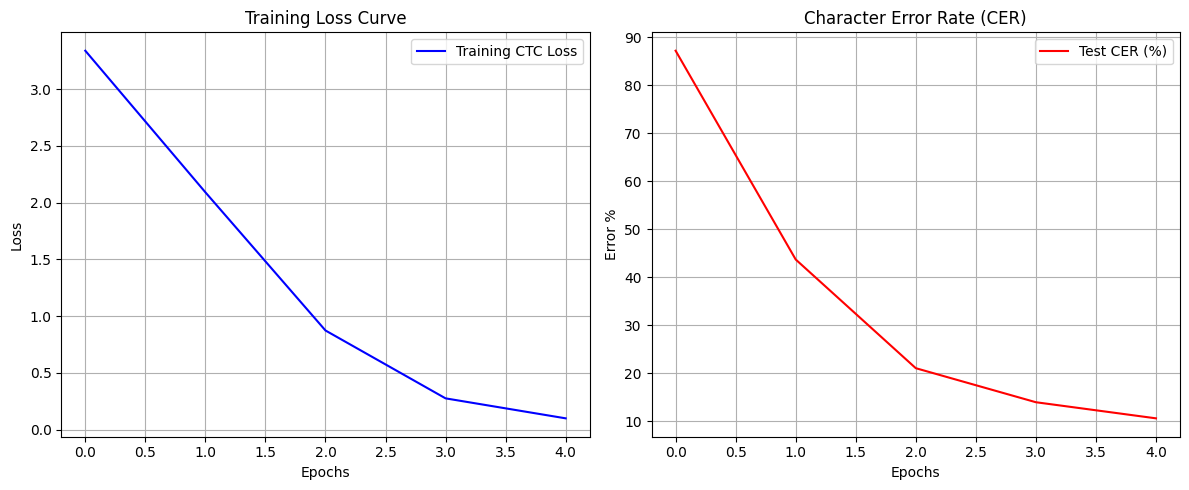

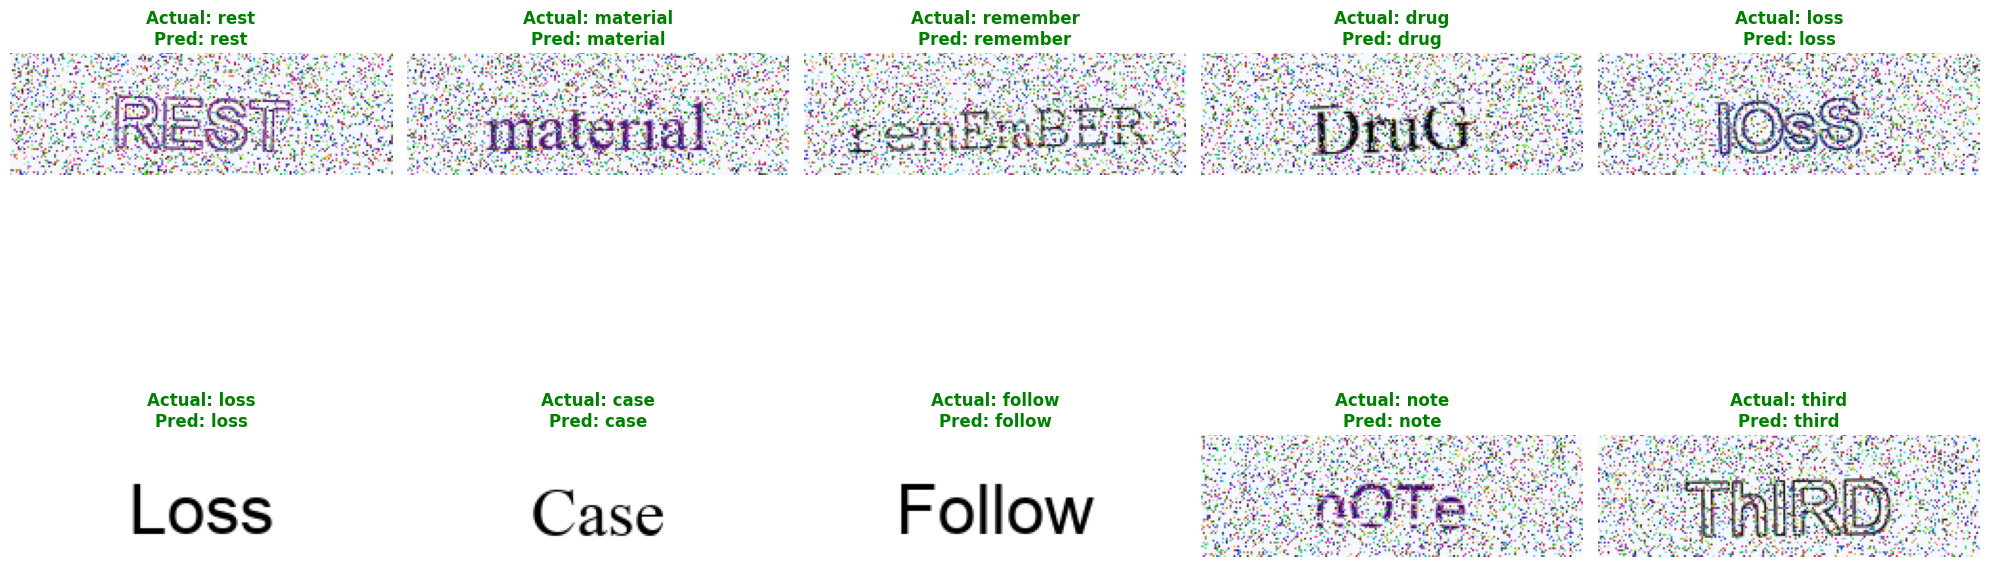

In [22]:
import clip # You'll need to pip install git+https://github.com/openai/CLIP.git

class CLIPBackboneOCR(nn.Module):
    def __init__(self, num_chars, device, hidden_size=256):
        super(CLIPBackboneOCR, self).__init__()
        # 1. Load CLIP's visual encoder
        # Using 'ViT-B/32' as it's very effective for detail
        self.clip_model, self.preprocess = clip.load("ViT-B/32", device=device)
        self.visual_encoder = self.clip_model.visual.float() # Use float32
        
        # 2. Sequence modeling
        # ViT-B/32 output is 512-dimensional
        self.rnn = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_chars + 1)

    def forward(self, x):
        # CLIP's ViT expects a specific shape and returns pooled features
        # For OCR, we extract the "patch" embeddings before the final pooling
        # Note: This requires accessing internal layers or using CLIP as a fixed extractor
        
        with torch.no_grad():
            # Get features from CLIP
            features = self.visual_encoder(x) # [Batch, 512]
            
        # Since pooled CLIP output is a single vector, for OCR we often treat it 
        # as one "time step" or use a Transformer decoder to expand it.
        # A more advanced version uses CLIP's patch embeddings.
        
        # Simple expansion to sequence
        x = features.unsqueeze(1).repeat(1, 10, 1) # Expand to 10 timesteps
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x.permute(1, 0, 2).log_softmax(2)
    
model = TransformerOCR(NUM_CHARS, d_model=256).to(DEVICE)
model_path = "best_clip_model"
run_pipeline(model, model_path, EPOCHS=5)